In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import random
from scipy.stats import skew, kurtosis
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.signal import spectrogram

import os
from signal_processing import DCBlockingFilter, WindowIIRNotchFilter, WindowButterBandpassFilter, WindowFilter
from features import extract_welch_features
import gc
gc.collect()

487

In [2]:
# Initialize filters for AF3 and AF4
def create_filter_chain(fs):
    return WindowFilter([
        DCBlockingFilter(alpha=0.99),
        # WindowIIRNotchFilter(60, 10, fs),
        # WindowIIRNotchFilter(50, 10, fs),
    ])
fs = 128
sampling_rate  =128

# keep_columns = [
#      'AF3', 'AF4', 'P7', 'P8', 'state'
# ]

keep_columns = [
    'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2',
    'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'state'
]

map_indexes = {'AF3':0, 'F7':1, 'F3':2, 'FC5':3, 'T7':4, 'P7':5, 'O1':6, 'O2':7,
    'P8':8, 'T8':9, 'FC6':10, 'F4':11, 'F8':12, 'AF4':13 }


def preprocess_dataset(file_path):
    """
    Load and preprocess EEG dataset.

    Parameters:
    - file_path: str, path to the CSV file.
    - row_limit: int or None, number of rows to limit for processing (None means no limit).

    Returns:
    - df: pandas DataFrame, the preprocessed DataFrame.
    """
    eeg_filter_AF3 = create_filter_chain(fs)
    eeg_filter_AF4 = create_filter_chain(fs)
    
    # Load the data and drop completely empty columns
    data = pd.read_csv(file_path)
    df = data.dropna(axis=1, how='all')


    # Remove rows with 'unfocused' state
    # df = df[df['state'] != 'unfocused']

    # Map 'state' to integers: 'focused' -> 1, 'drowsed' -> 0
    df['state'] = df['state'].map({'focused': 2, 'drowsed': 0,'unfocused':1})

    # keep_columns = [
    #     'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2',
    #     'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'state'
    # ]
    # df['Fz'] = (df['AF3'] + df['AF4'])/2
    # df['Cz'] = (df['O1'] + df['O2'])/2

    
    for col in keep_columns[:-1]:
        df[col] = eeg_filter_AF3.filter_data(df[col].to_numpy())
        
    if 'filename' in df.columns:
        keep_columns.append('filename')

    df = df[keep_columns]

    return df

hop_len = sampling_rate 
# @title save_welch_data
def save_welch_data(df, window_size, sampling_rate):
    
    save_to_csv = {key: [] for key in ['filename', 'state']}
    # Remove 'filename' and 'state' columns once, avoid doing it repeatedly inside the loop
    signal_columns = [col for col in df.columns if col not in ['filename', 'state']]

    # Group the DataFrame by 'filename' to avoid filtering in each loop
    grouped = df.groupby('filename', sort=False)

    # Initialize lists for features and labels
    features = []
    labels = []

    for file, file_df in grouped:
        # Calculate the number of windows at the start
        # num_windows = len(file_df) // window_size
        # num_windows = min (len(file_df), sampling_rate*60*20) // window_size
        # numSamples = min (len(file_df), sampling_rate*60*20)
        numSamples = len(file_df)
        print(numSamples//sampling_rate)
        num_windows = (numSamples - window_size +hop_len)// hop_len
        # Iterate through windows and calculate features
        for i in range(num_windows):
            save_to_csv['filename'].append(file)

            window_df = file_df.iloc[i * hop_len:i*hop_len +  window_size]

            # Extract features from all signal columns
            channel_features = []
            for col in signal_columns:
              welch_ = extract_welch_features(window_df[col].values, fs=sampling_rate)
              welch_name = [f"welch_{name}" for name in range(len(welch_))]
              for idx, name in enumerate(welch_name):
                name_col = f"{name}_{col}"
                if name_col in save_to_csv:
                  save_to_csv[name_col].append(welch_[idx])
                else:
                  save_to_csv[name_col] = [welch_[idx]]


              channel_features.append(welch_)

            # Concatenate and append features
            features.append(np.concatenate(channel_features))
            
            numCount = [0] * 3
            numCount[1] = np.count_nonzero(window_df['state'] == 1)
            numCount[0] = np.count_nonzero(window_df['state'] == 0)
            numCount[2] = np.count_nonzero(window_df['state'] == 2)

            representative_value = np.argmax(numCount)
            # representative_value = window_df['state'].iloc[-1]
          
            # Append the corresponding label
            labels.append(representative_value)
            save_to_csv['state'].append(representative_value)

    return np.array(features), np.array(labels), save_to_csv

In [4]:
csv_path = 'preprocessed_eeg_data.csv'

df = preprocess_dataset(csv_path)

print(df.shape)
df.head()

(12512552, 16)


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,state,filename
0,4439.000000,-18.168172,1379.773280,-1222.279972,189.700791,621.146094,422.517832,123.117653,538.426427,128.107098,-178.340359,143.123465,49.208538,228.688554,2,eeg_record1.mat
1,4394.097179,-17.986490,1364.437085,-1213.646916,188.316604,617.498736,415.215730,121.373656,530.478060,126.826027,-165.787725,142.717872,45.126709,229.478591,2,eeg_record1.mat
2,4349.643387,-20.883548,1347.202971,-1202.023268,184.382156,608.246826,406.448188,120.159919,526.711741,125.557766,-147.719591,139.752231,46.726724,218.465857,2,eeg_record1.mat
3,4306.146953,-25.290097,1329.115556,-1187.951753,180.999873,595.497691,398.281142,113.830115,519.393342,124.815009,-141.114190,138.354709,46.772277,211.152993,2,eeg_record1.mat
4,4263.598304,-28.114119,1313.260298,-1176.585056,182.266797,588.004252,393.272690,111.153352,505.481459,122.028398,-139.703048,139.535265,46.304554,202.887617,2,eeg_record1.mat


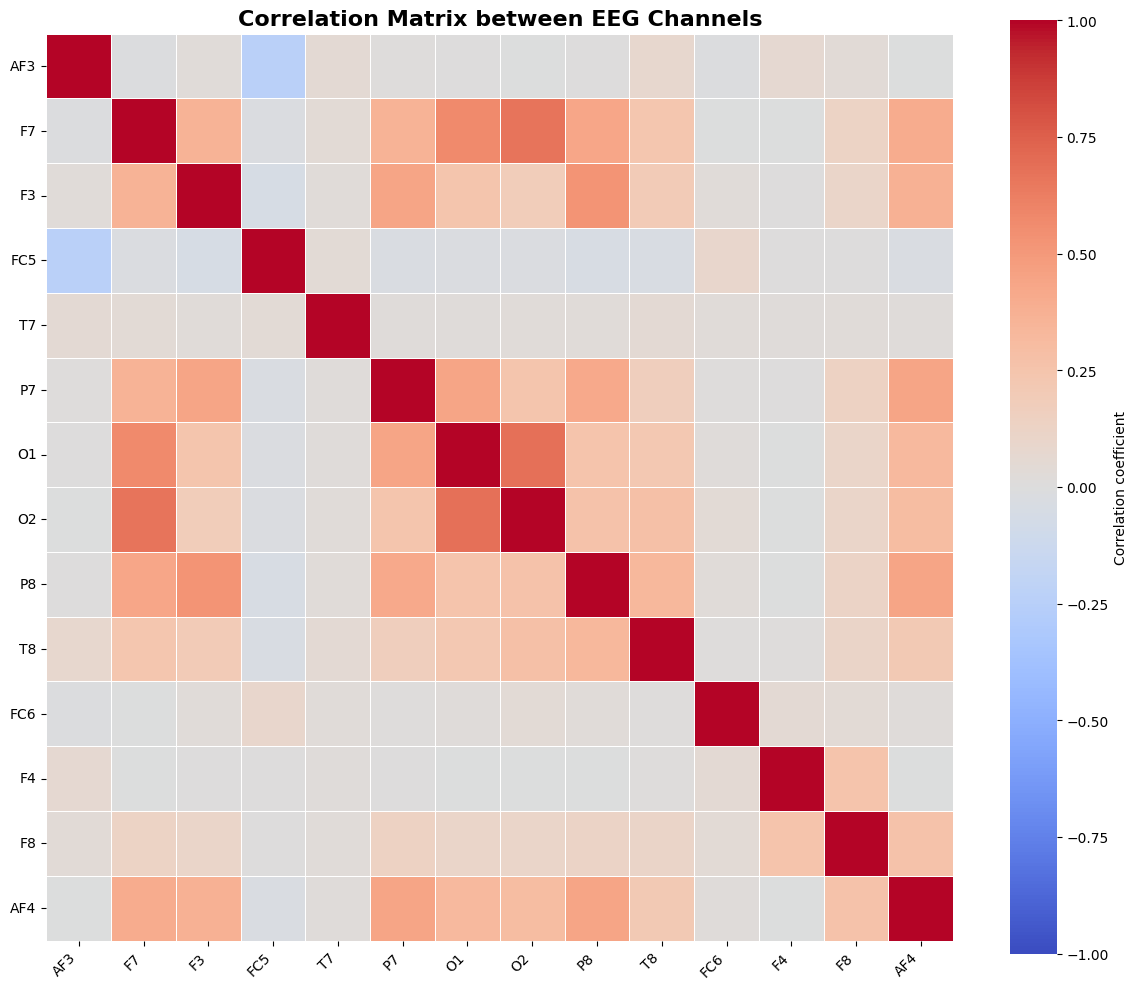

In [7]:
channel_cols = [col for col in df.columns if col not in ['state', 'filename']]
corr_matrix = df[channel_cols].corr()

# === Plot correlation heatmap ===
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={'label': 'Correlation coefficient'}
)
plt.title("Correlation Matrix between EEG Channels", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("channel_correlation.pdf", bbox_inches="tight", pad_inches=0.2)
plt.show()

In [44]:
window_size = 8*sampling_rate
_, _, save_to_csv = save_welch_data(df, window_size, sampling_rate)
df_welch = pd.DataFrame(save_to_csv)
# df_welch = df_welch.sort_values(by=['filename']).reset_index(drop=True)
df_welch.to_csv('welch_data_8s_14c.csv', index=False, header=True, encoding='utf-8')

2413
2979


/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:255: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)


3059
2786
2916
2696
2805
1831
3468
2826
2603
2859
3100
2627
2537
2715
1676
3317
2790
2726
3350
3779
3776
3195
2971
2743
2255
3115
2858
3037


In [9]:
# del df
# gc.collect()
def create_features_without_initial(df, frame_size=64, features_to_add = None):
    """
    Create features by concatenating N sequential rows (default N=4).
    
    Parameters:
    - df: input dataframe with columns: [index, label, features...]
    - frame_size: number of sequential rows to stack
    - label_mode: 'last' (default) or 'all'
    
    Returns:
    - X: shape (num_samples, frame_size * num_features)
    - y: shape (num_samples,) or (num_samples, frame_size)
    """
    
    df = (df.groupby(df.columns[0], group_keys=False).head(60*30))
    
    # if features_to_add == None:
    #     features = df.iloc[:, 2:].values  # shape: (N, F)
    #     labels = df.iloc[:, 1].values     # shape: (N,)
    # else:
    #     features = df[features_to_add]
    #     labels = df['state']
        
    
    grouped = df.groupby('filename')
    X = []
    y = []
    for _, group in grouped:

        if features_to_add == None:
            features = group.iloc[:, 2:].values  # shape: (N, F)
            labels = group['state'].values     # shape: (N,)
        else:
            features = group[features_to_add].values  # shape: (N, F)
            labels = group['state'].values       # shape: (N,)
        


        # Create windows for this filename
        for i in range(len(group) - frame_size + 1):
            window_feats = features[i:i+frame_size, :].flatten()
            X.append(window_feats)
            y.append(labels[i + frame_size - 1])
    
    return X, y

56938
20400
20162


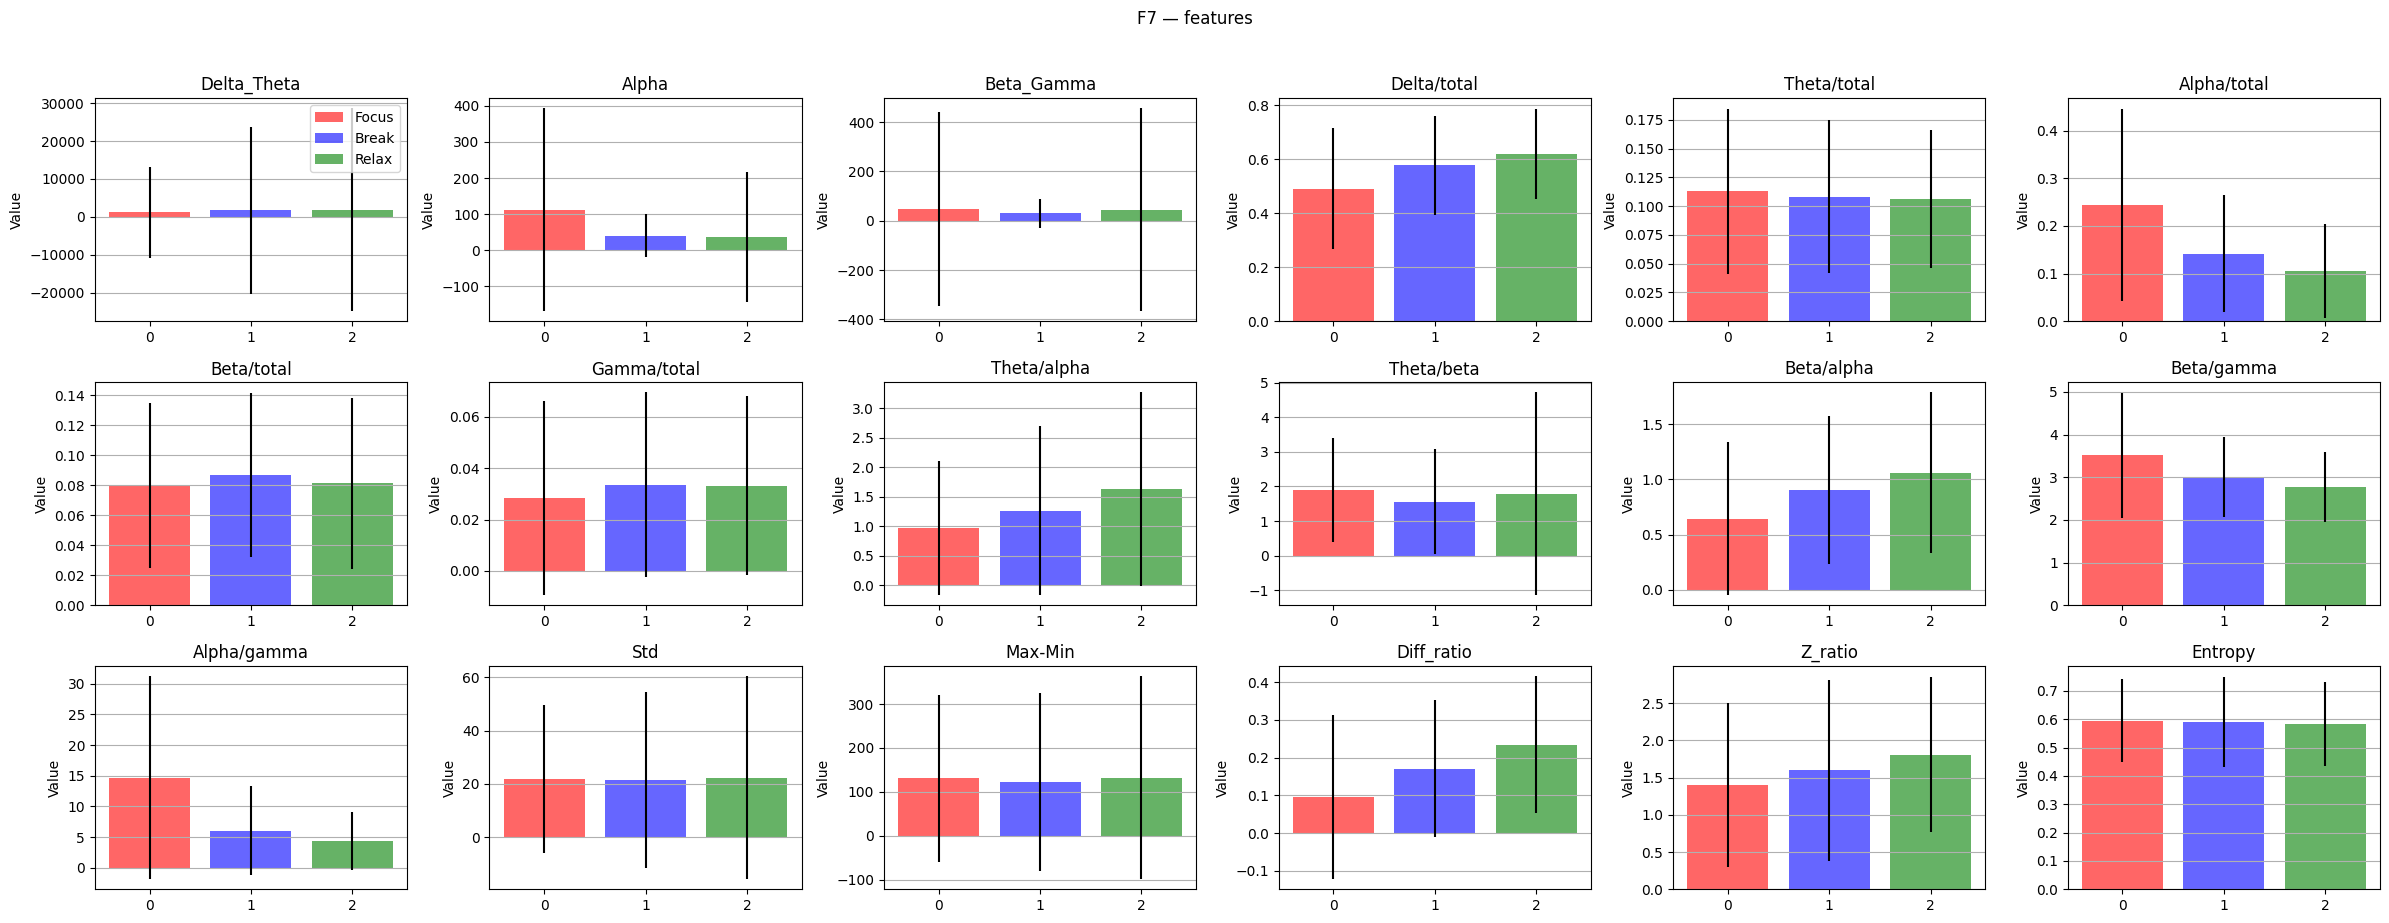

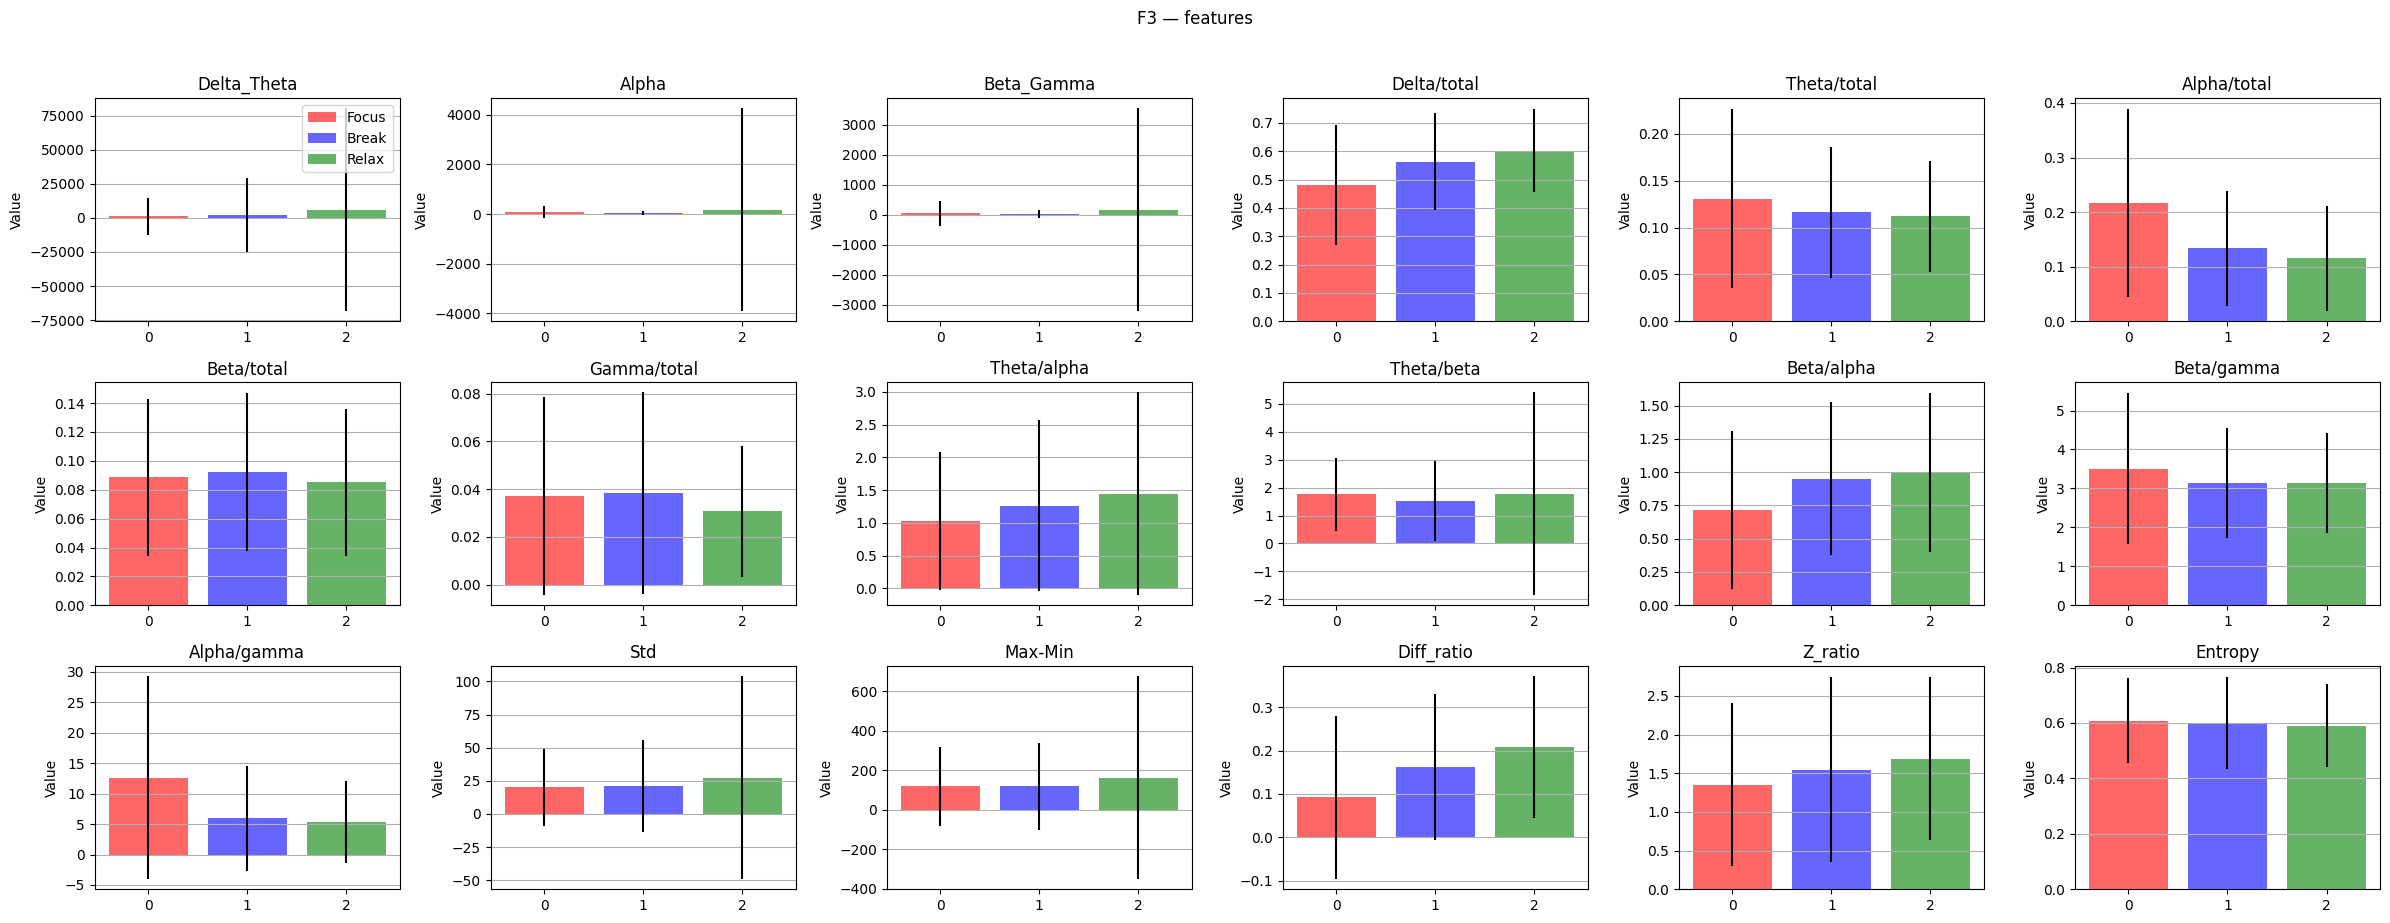

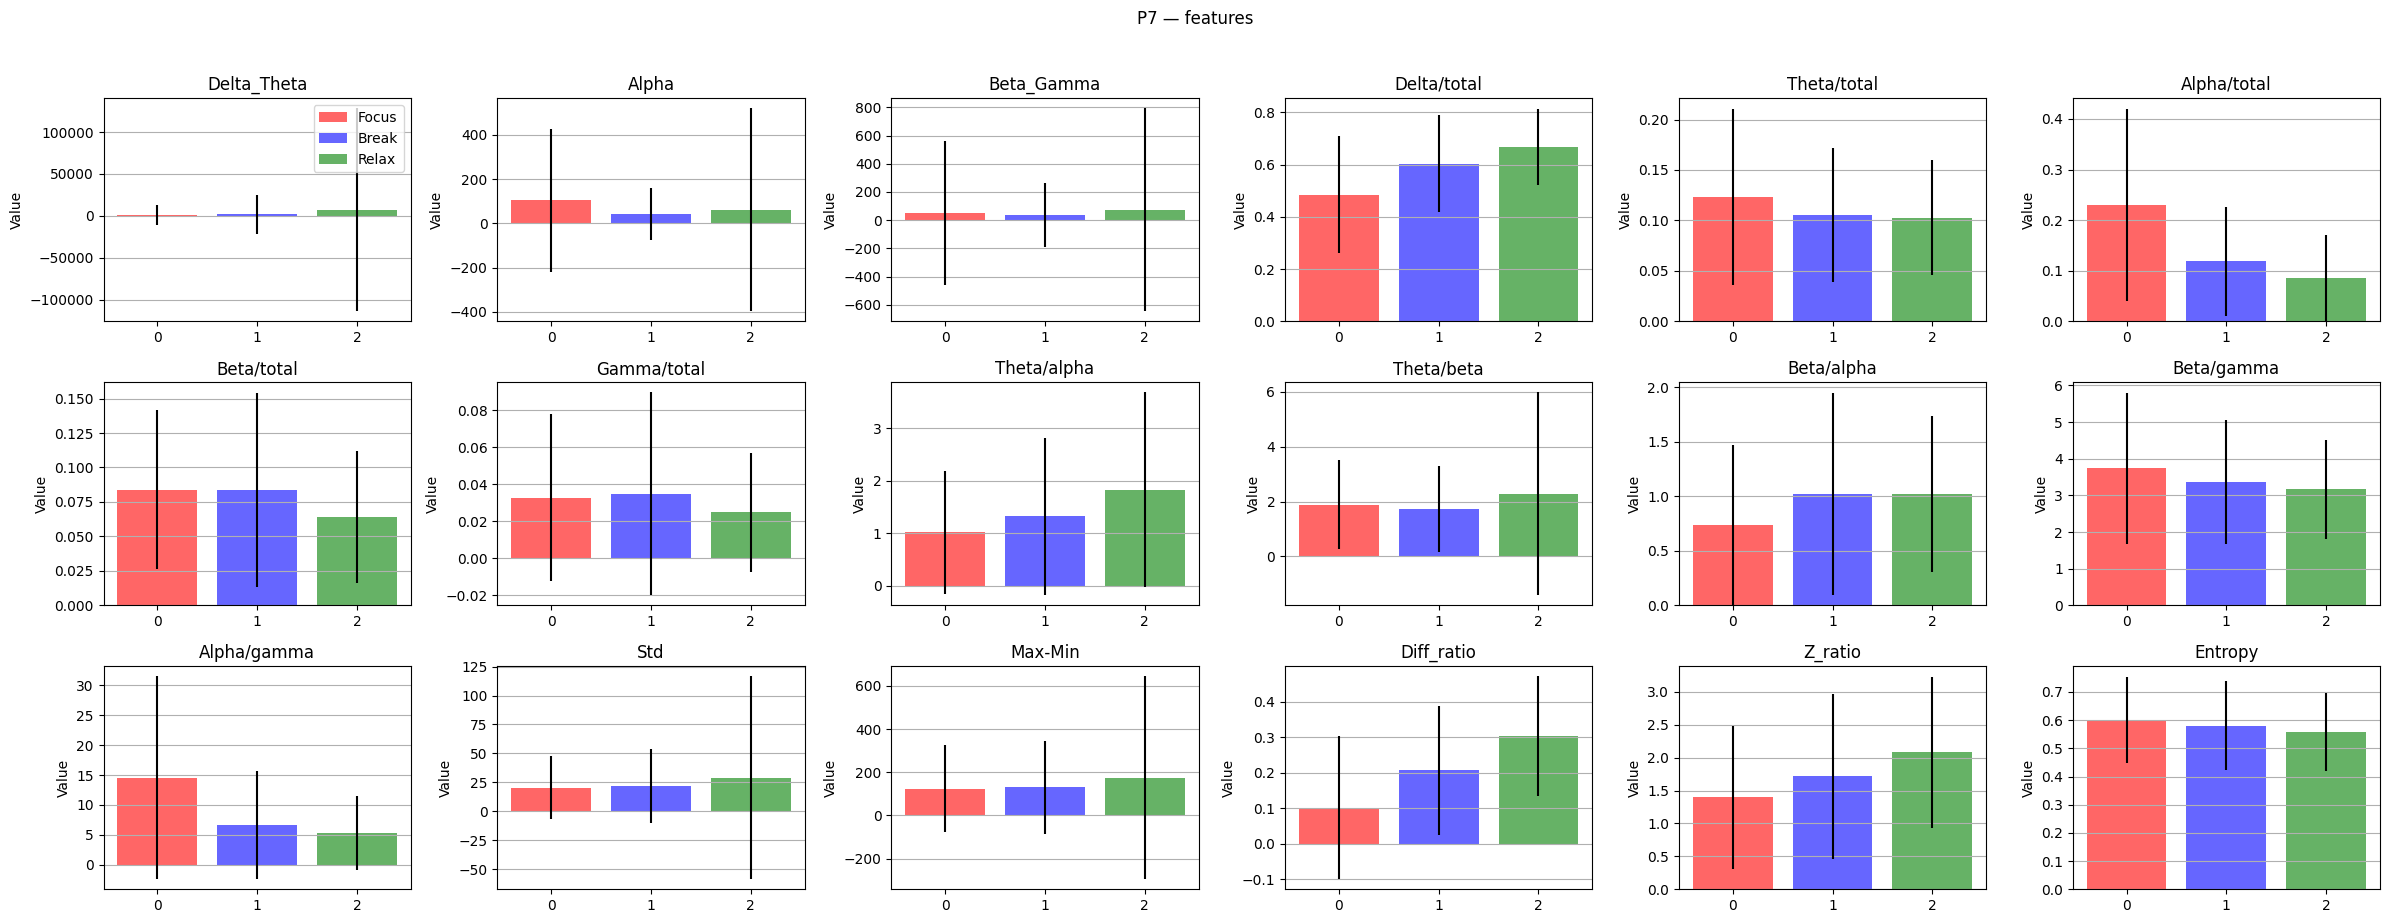

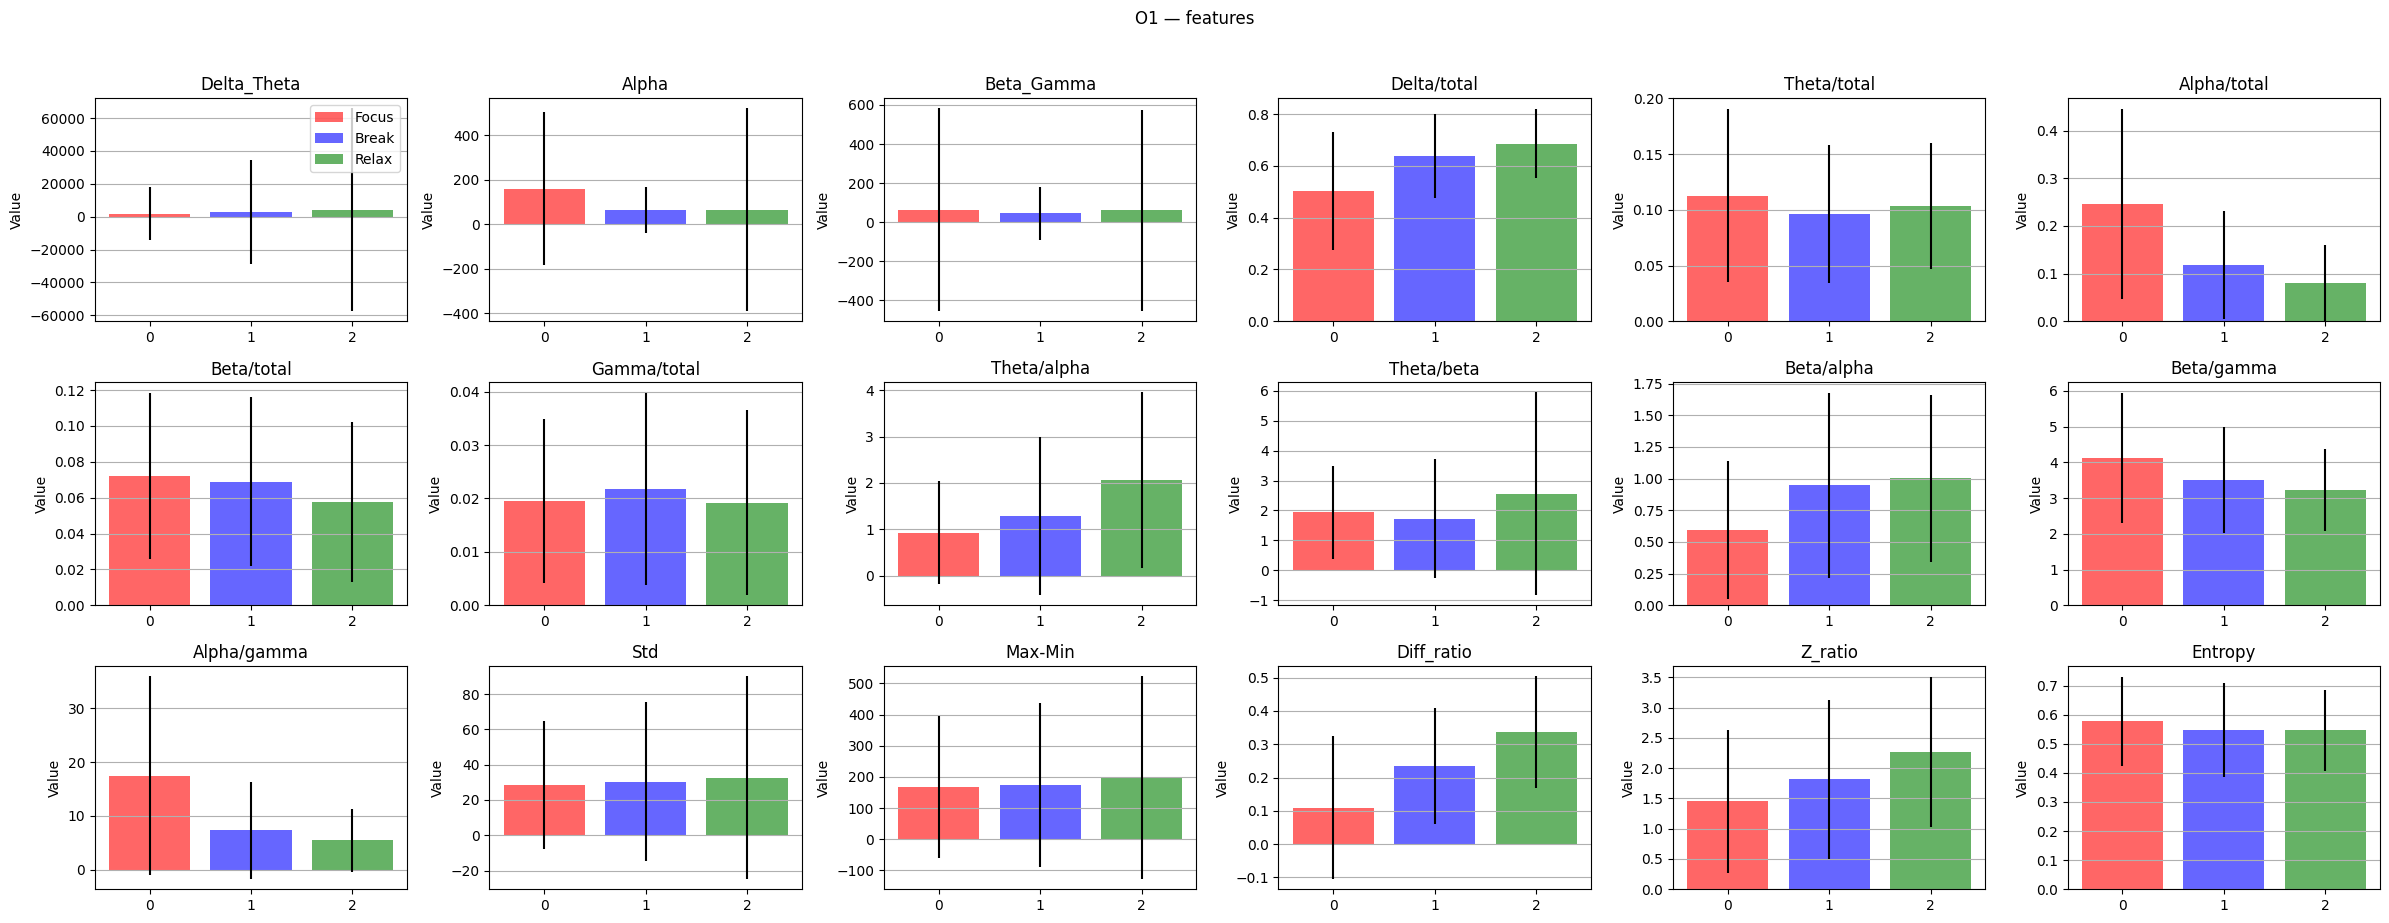

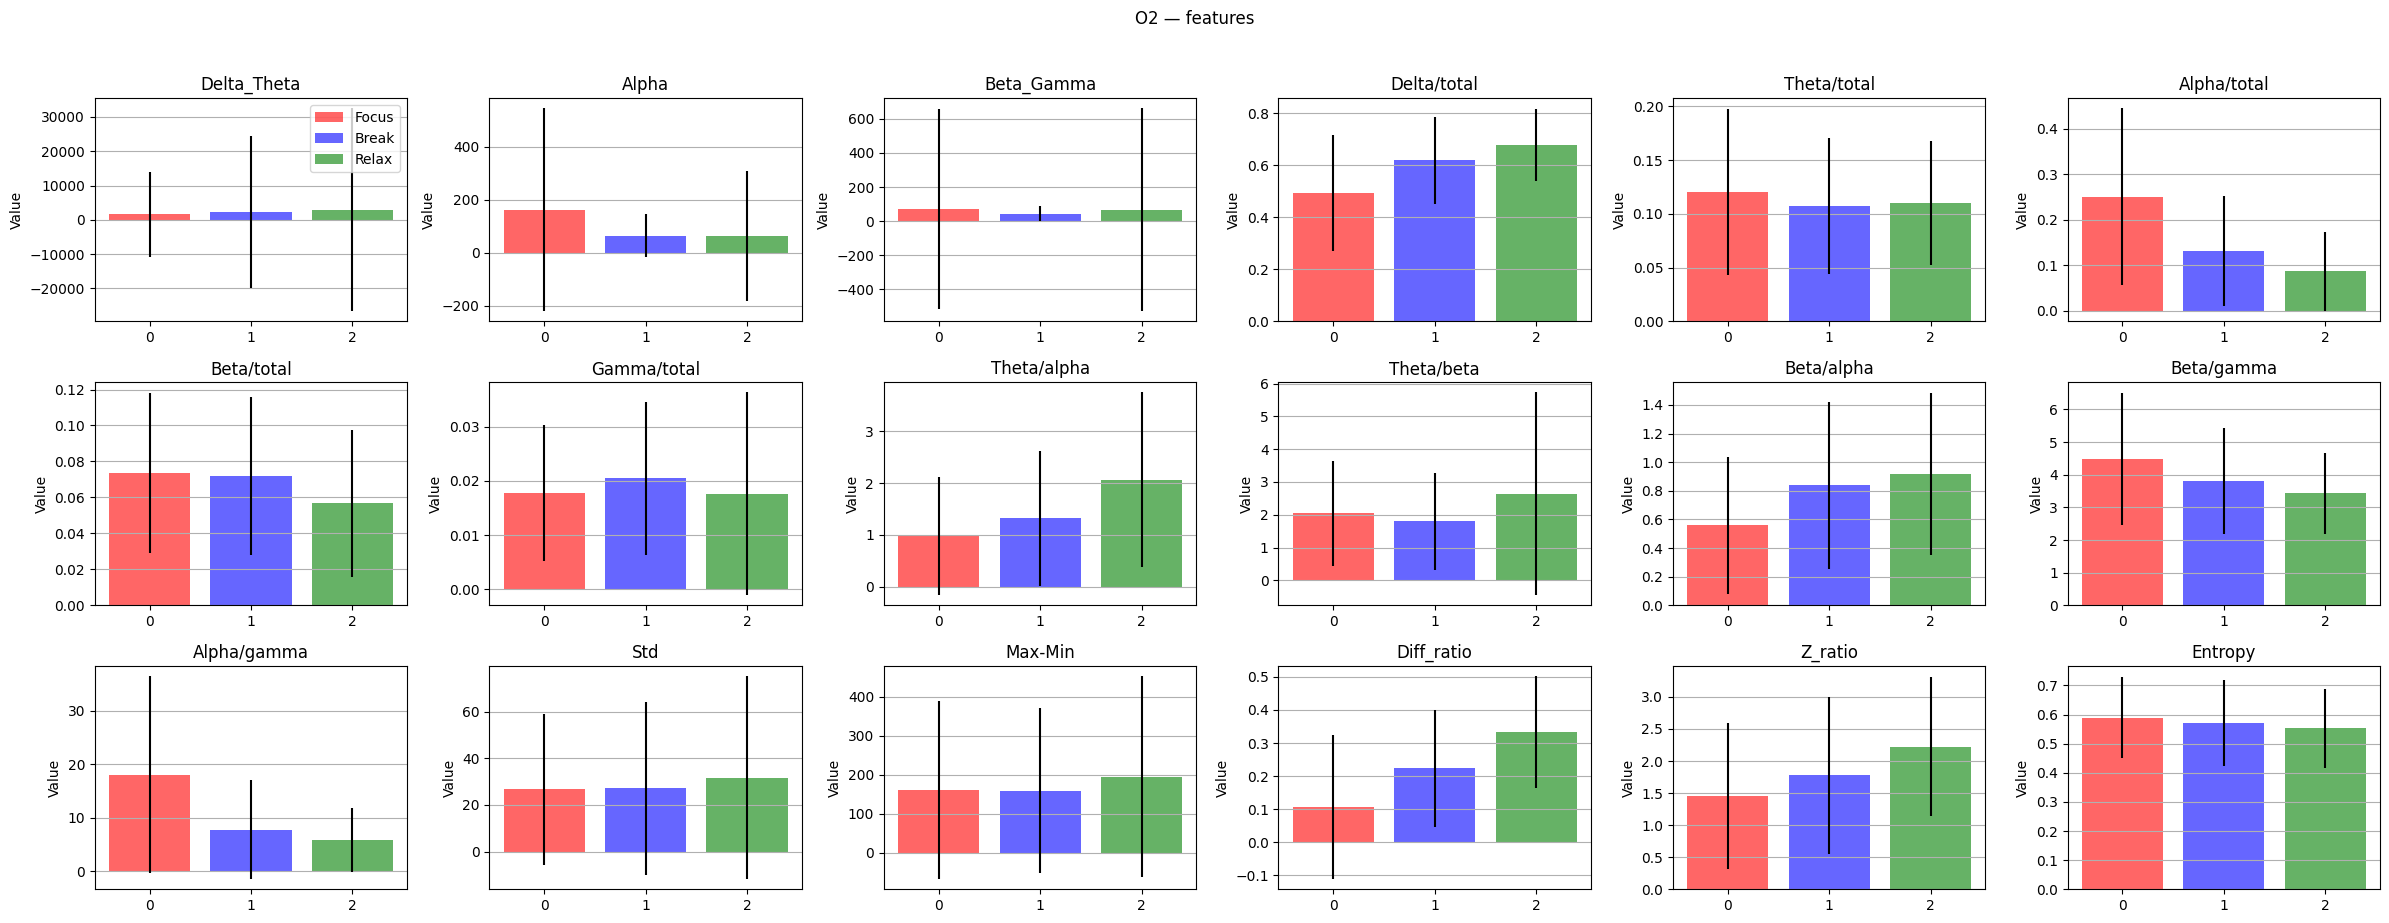

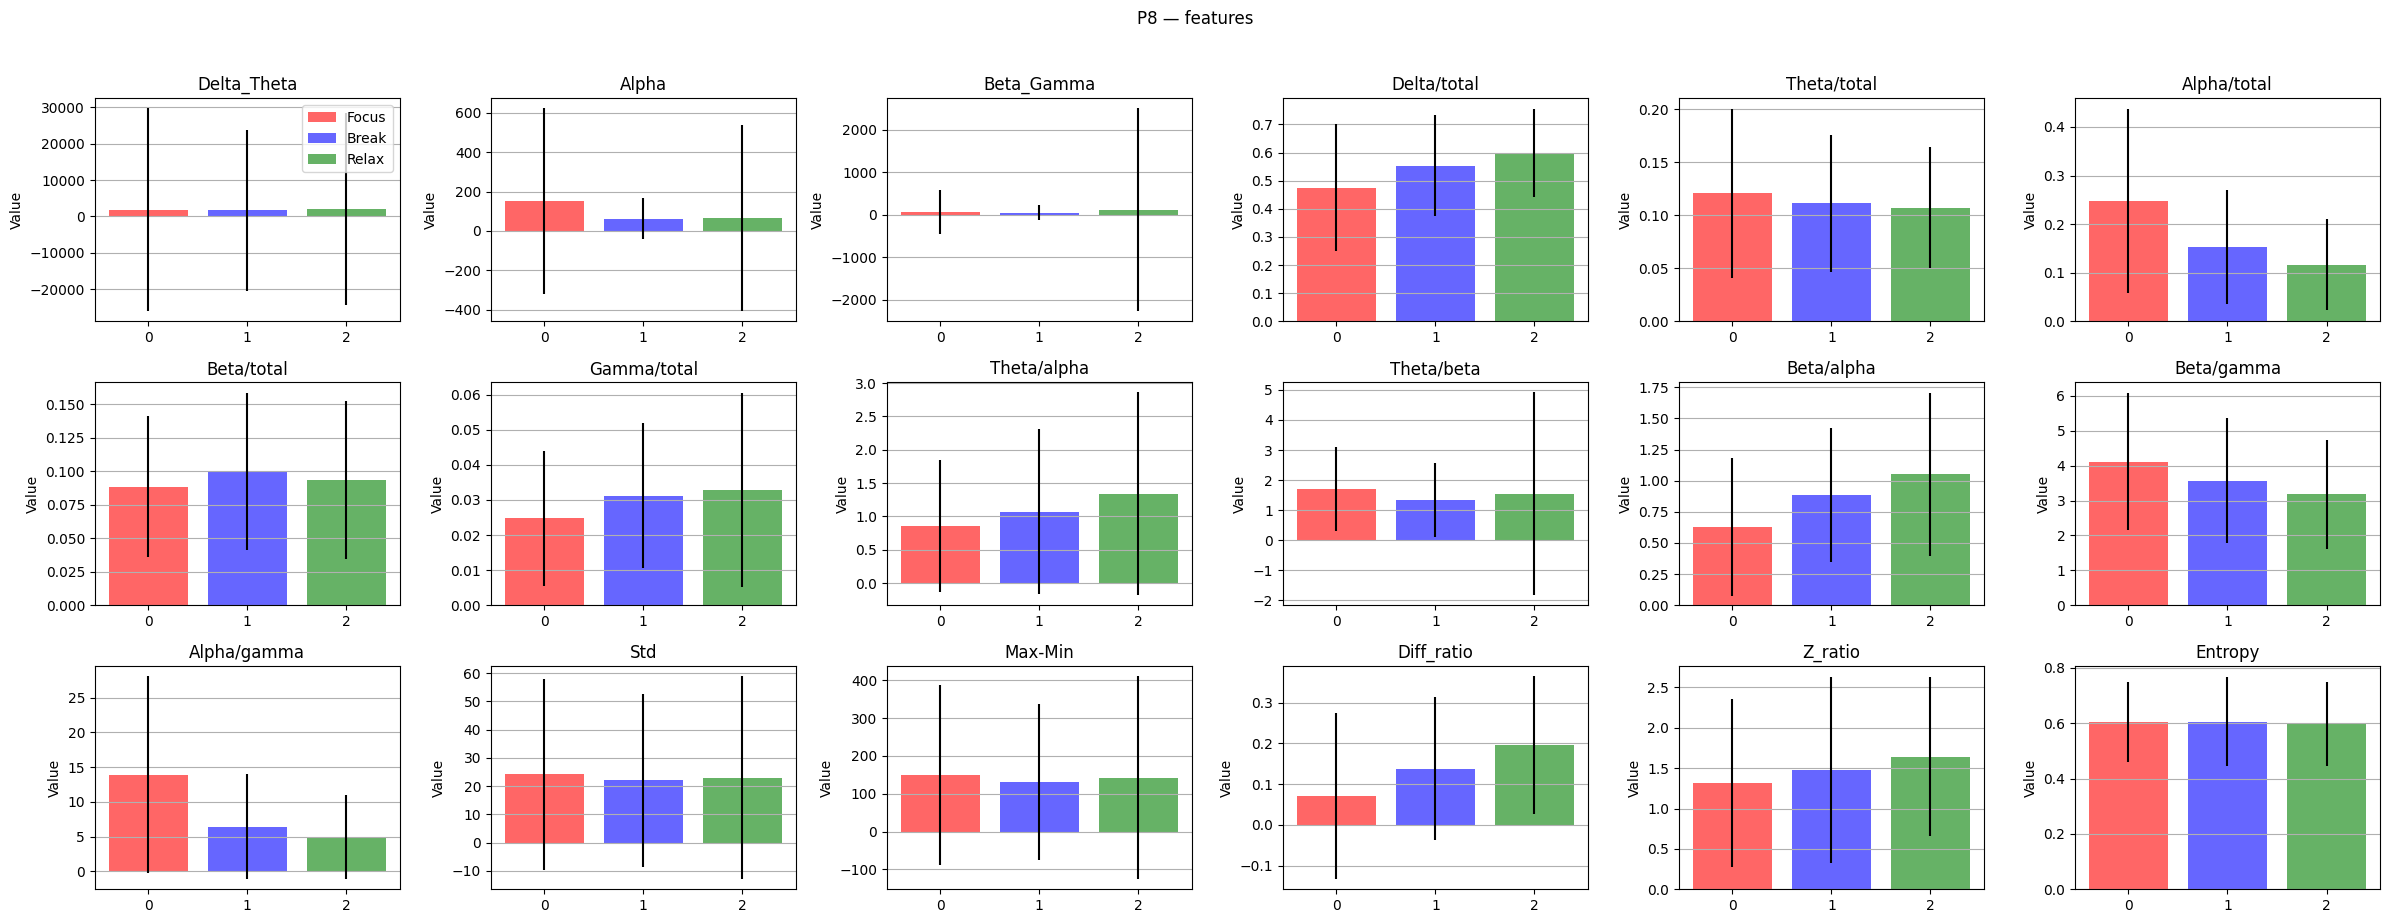

In [18]:

FEATURE_NAMES = [
    "Delta_Theta","Alpha","Beta_Gamma",
    "Delta/total","Theta/total","Alpha/total","Beta/total","Gamma/total",
    "Theta/alpha","Theta/beta","Beta/alpha","Beta/gamma","Alpha/gamma",
    "Std","Max-Min","Diff_ratio","Z_ratio","Entropy"
]

Plot_Channels = ['F7', 'F3', 'P7', 'O1', 'O2', 'P8']

from scipy.stats import f_oneway
from math import ceil


def plot_feature_mean_std_by_label_per_channel(df, channel_size=18, cols=6, selected_channels = None):   
    features = df.iloc[:, 2:].values  # shape: (N, F)
    labels = df.iloc[:, 1].values     # shape: (N,)
    features = np.asarray(features)
    labels = np.asarray(labels).ravel()
    num_features = features.shape[1]

    # Split by label
    features_2 = features[labels == 2]  # Relax
    features_1 = features[labels == 1]  # Break
    features_0 = features[labels == 0]  # Focus
    
    print(len(features_0))
    print(len(features_1))
    print(len(features_2))

    # Mean and std per label
    mean_0 = np.mean(features_0, axis=0); std_0 = np.std(features_0, axis=0)
    mean_1 = np.mean(features_1, axis=0); std_1 = np.std(features_1, axis=0)
    mean_2 = np.mean(features_2, axis=0); std_2 = np.std(features_2, axis=0)

    # How many channels (assumes 18 features per channel in channel-major order)
    if num_features % channel_size != 0:
        print(f"Warning: {num_features} is not a multiple of {channel_size}. "
              "Extra features will be ignored.")
    num_channels = num_features // channel_size
    
    if selected_channels==None:
        list_idx = [i for i in range(num_channels)]
    else:
        list_idx = [map_indexes[ch] for ch in selected_channels]
        
        
    results_dict = {}    

    for idx_ch, ch in enumerate(list_idx):
        start = ch * channel_size
        end   = start + channel_size
        
        pvals = []
  
        rows = int(np.ceil(channel_size / cols))
        plt.figure(figsize=(cols * 4, rows * 3))

        for j in range(channel_size):
            i = start + j  
            
            a0 = features_0[:, i]
            a1 = features_1[:, i]
            a2 = features_2[:, i]

            # Guard against empty groups
            if (a0.size == 0) or (a1.size == 0) or (a2.size == 0):
                pval = np.nan
            else:
                _, pval = f_oneway(a0, a1)
            pvals.append(pval)
            
            
            
            plt.subplot(rows, cols, j + 1)

            # Bars: Focus(0), Break(1), Relax(2)
            plt.bar([0], [mean_0[i]], yerr=[std_0[i]], color='red',  alpha=0.6, label='Focus')
            plt.bar([1], [mean_1[i]], yerr=[std_1[i]], color='blue', alpha=0.6, label='Break')
            plt.bar([2], [mean_2[i]], yerr=[std_2[i]], color='green',alpha=0.6, label='Relax')

            fname = FEATURE_NAMES[j]
            plt.title(f"{fname}")
            plt.xticks([0, 1, 2], ["0", "1", "2"])
            plt.ylabel("Value")
            plt.grid(True, axis='y')

            if j == 0:
                plt.legend()
                

        plt.suptitle(f"{keep_columns[ch]} — features", y=1.02)
        plt.tight_layout()
        plt.show()
        
        
        if selected_channels is not None:
            results_dict[selected_channels[idx_ch]] = pvals
            
    df_ANOVA = pd.DataFrame(results_dict)
    df_ANOVA = df_ANOVA.round(5)
    df_ANOVA.to_csv("ANOVA.csv", index=False, float_format=f"%.{5}f")
    
        
        
        
df_welch = pd.read_csv("welch_data_8s_14c.csv")  
plot_feature_mean_std_by_label_per_channel(df_welch, channel_size=len(FEATURE_NAMES), cols=6, selected_channels = Plot_Channels)

['F7', 'F3', 'P7', 'O1', 'O2', 'P8']


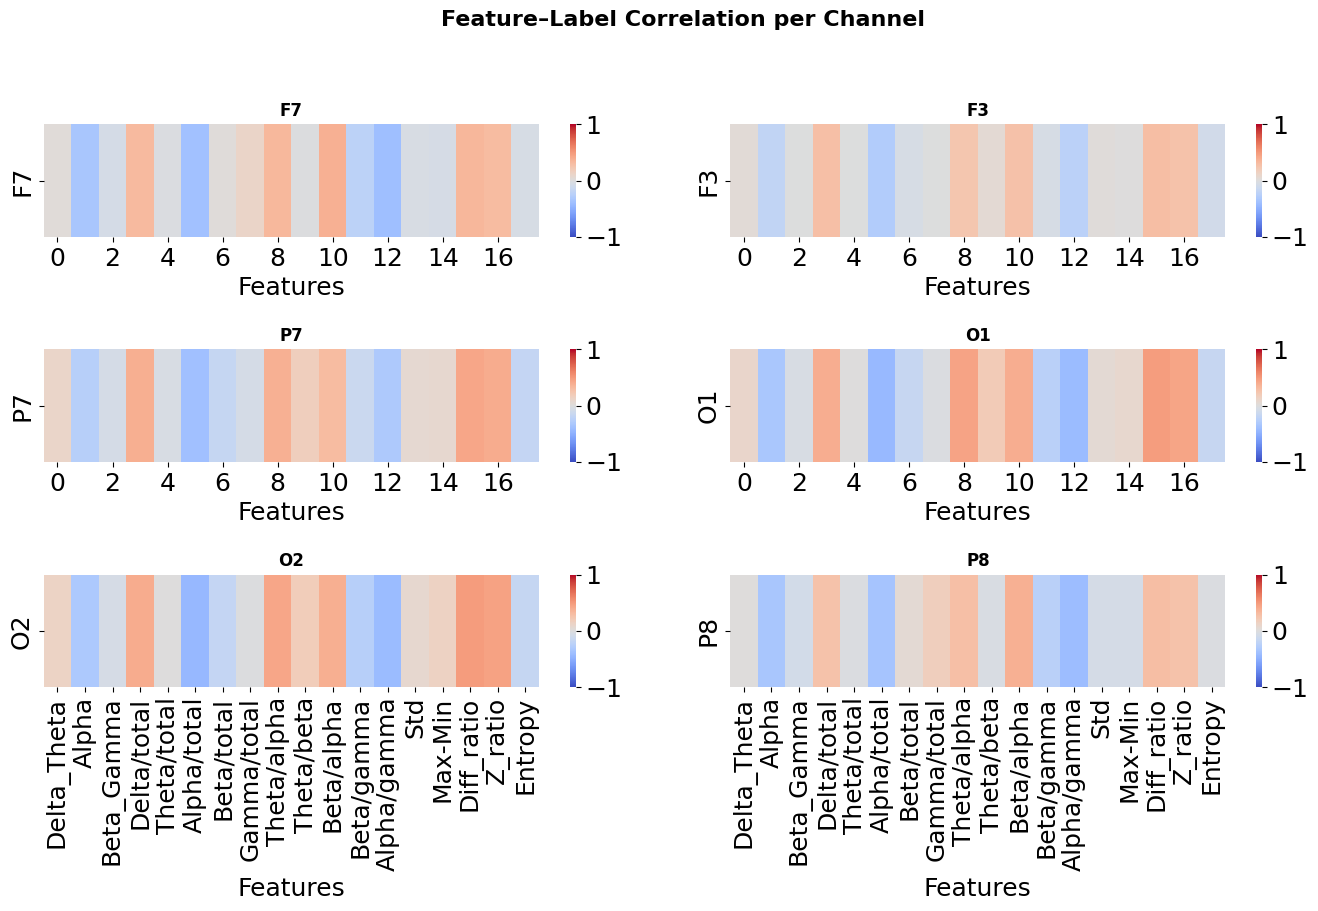

Feature F7 F3 P7 O1 O2 P8
Delta_Theta 0.027160 0.035883 0.102645 0.101306 0.128365 0.015147
Alpha -0.340961 -0.190229 -0.256616 -0.330598 -0.315863 -0.342076
Beta_Gamma -0.066517 -0.003877 -0.065758 -0.045011 -0.061429 -0.083736
Delta/total 0.314290 0.283904 0.383948 0.391570 0.401778 0.260429
Theta/total -0.015707 -0.005021 -0.042744 0.000521 0.004566 -0.023048
Alpha/total -0.379218 -0.283422 -0.386418 -0.436660 -0.438889 -0.351812
Beta/total 0.020438 -0.047951 -0.169940 -0.161880 -0.177929 0.054537
Gamma/total 0.113122 -0.001720 -0.063348 -0.023307 -0.009964 0.168957
Theta/alpha 0.328545 0.235115 0.375918 0.451274 0.434908 0.285453
Theta/beta -0.008974 0.052690 0.164333 0.196842 0.181516 -0.033879
Beta/alpha 0.378686 0.268375 0.309076 0.396676 0.389006 0.375819
Beta/gamma -0.221092 -0.050198 -0.137480 -0.242077 -0.254191 -0.236666
Alpha/gamma -0.398163 -0.230139 -0.308643 -0.416721 -0.420688 -0.412738
Std -0.039112 0.018258 0.063732 0.049307 0.071014 -0.064247
Max-Min -0.058696 0.005

In [73]:
def corr_per_file_and_average(df,
                              frame_size=1,
                              per_channel_feats=18, selected_channels = None):
    if selected_channels is None:
        channels = [c for c in keep_columns if c != 'state']
    else:
        channels = [c for c in selected_channels if c != 'state']
        
    n_channels = len(channels)
    
    list_cols = np.concatenate([
    np.arange(map_indexes[ch] * per_channel_feats, (map_indexes[ch] + 1) * per_channel_feats)
    for ch in selected_channels]).astype(int)
   
    corr_by_file = {}
    for fname, g in df.groupby('filename'):
        g_filter = g.iloc[:, 2+ list_cols]
        X = np.asarray(g_filter.values, dtype=float)
        y = np.asarray(g.iloc[:, 1].values, dtype=float).ravel()


        # finite mask
        m = np.isfinite(X).all(axis=1) & np.isfinite(y)
        Xf = X[m]; yf = y[m]

        r_vec = np.full(Xf.shape[1], np.nan)
        for i in range(Xf.shape[1]):
            xi = Xf[:, i]
            if np.std(xi) == 0:
                r = np.nan
            else:
                r = np.corrcoef(xi, yf)[0, 1]
            r_vec[i] = r
        corr_by_file[fname] = r_vec

    if not corr_by_file:
        raise ValueError("No valid per-file correlations computed. Check data/labels per filename.")

    A = np.vstack(list(corr_by_file.values()))  # shape: (n_files, n_features)

    # Simple mean of r (ignoring NaN)
    mean_r = np.nanmean(A, axis=0)

    # Fisher z-mean (more stable): z = arctanh(r), then average, then tanh back
    Z = np.arctanh(np.clip(A, -0.999999, 0.999999))
    z_mean = np.nanmean(Z, axis=0)
    # mean_r_fisher = np.tanh(z_mean)

    avg = mean_r
    
    
    return avg, mean_r, mean_r_fisher, corr_by_file, channels

def plot_heatmaps_from_avg(avg_corr, channels=None, per_channel_feats=18, save=True):
    avg_corr = np.asarray(avg_corr, dtype=float).ravel()
    total_feats = avg_corr.size
    n_channels = total_feats // per_channel_feats

    # Build channel names if not given
    if channels is None:
        channels = [f"Ch{c}" for c in range(n_channels)]
    elif len(channels) != n_channels:
        print(f"[WARN] channels={len(channels)} but derived n_channels={n_channels} "
              f"from avg_corr ({total_feats} feats / {per_channel_feats} per channel). "
              f"Using first {n_channels} names.")
        channels = channels[:n_channels]

    
    selected_idx = [i for i, ch in enumerate(channels) if ch in Plot_Channels]

    # Create subplots — layout is automatic based on number of selected channels
    n_plots = len(selected_idx)
    n_cols = 2
    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows))
    axes = axes.flatten()

    for ax_idx, ch_idx in enumerate(selected_idx):
        ch_name = channels[ch_idx]
        s = ch_idx * per_channel_feats
        e = s + per_channel_feats
        if e <= s or e > total_feats:
            print(f"[SKIP] Channel {ch_name}: slice {s}:{e} invalid for length {total_feats}")
            continue

        corr_slice_row = avg_corr[s:e].reshape(1, -1)
        feat_names = FEATURE_NAMES[:(e - s)]
        if ax_idx== len(selected_idx)-1 or ax_idx== len(selected_idx)-2:
            sns.heatmap(
                corr_slice_row,
                annot=False,
                cmap="coolwarm",
                center=0,
                cbar=True,
                xticklabels=feat_names,
                yticklabels=[ch_name],
                vmin=-1,
                vmax=1,
                ax=axes[ax_idx])
        else:
             sns.heatmap(
                corr_slice_row,
                annot=False,
                cmap="coolwarm",
                center=0,
                cbar=True,
                yticklabels=[ch_name],
                vmin=-1,
                vmax=1,
                ax=axes[ax_idx])
        axes[ax_idx].set_title(f"{ch_name}", fontsize=12, fontweight="bold")
        axes[ax_idx].set_xlabel("Features")
        axes[ax_idx].set_ylabel("")

    # Hide unused subplots (if any)
    for j in range(ax_idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Feature–Label Correlation per Channel", fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout()

    if save:
        plt.savefig("Channels_GT_Corr_All.pdf", bbox_inches="tight", pad_inches=0.2)

    plt.show()

def print_feature_table_from_avg(avg_corr, channels=None, per_channel_feats=18):
    a = np.asarray(avg_corr, dtype=float).ravel()
    n_ch = len(a) // per_channel_feats
    if channels is None:
        channels = [f"Ch{c}" for c in range(n_ch)]
  
    print("Feature " + " ".join(channels))
    for f_idx, fname in enumerate(FEATURE_NAMES[:per_channel_feats]):
        vals = [a[ch * per_channel_feats + f_idx] for ch in range(n_ch)]
        print(fname, *[f"{v:.6f}" for v in vals])
    

df_welch = pd.read_csv("welch_data_8s_14c.csv")    
avg_corr, mean_r, mean_r_fisher, corr_by_file, channels = corr_per_file_and_average(df_welch, selected_channels = Plot_Channels)
print(channels)
plot_heatmaps_from_avg(avg_corr, channels)
print_feature_table_from_avg(avg_corr, channels=Plot_Channels,per_channel_feats=len(FEATURE_NAMES))

20507
20400
20162


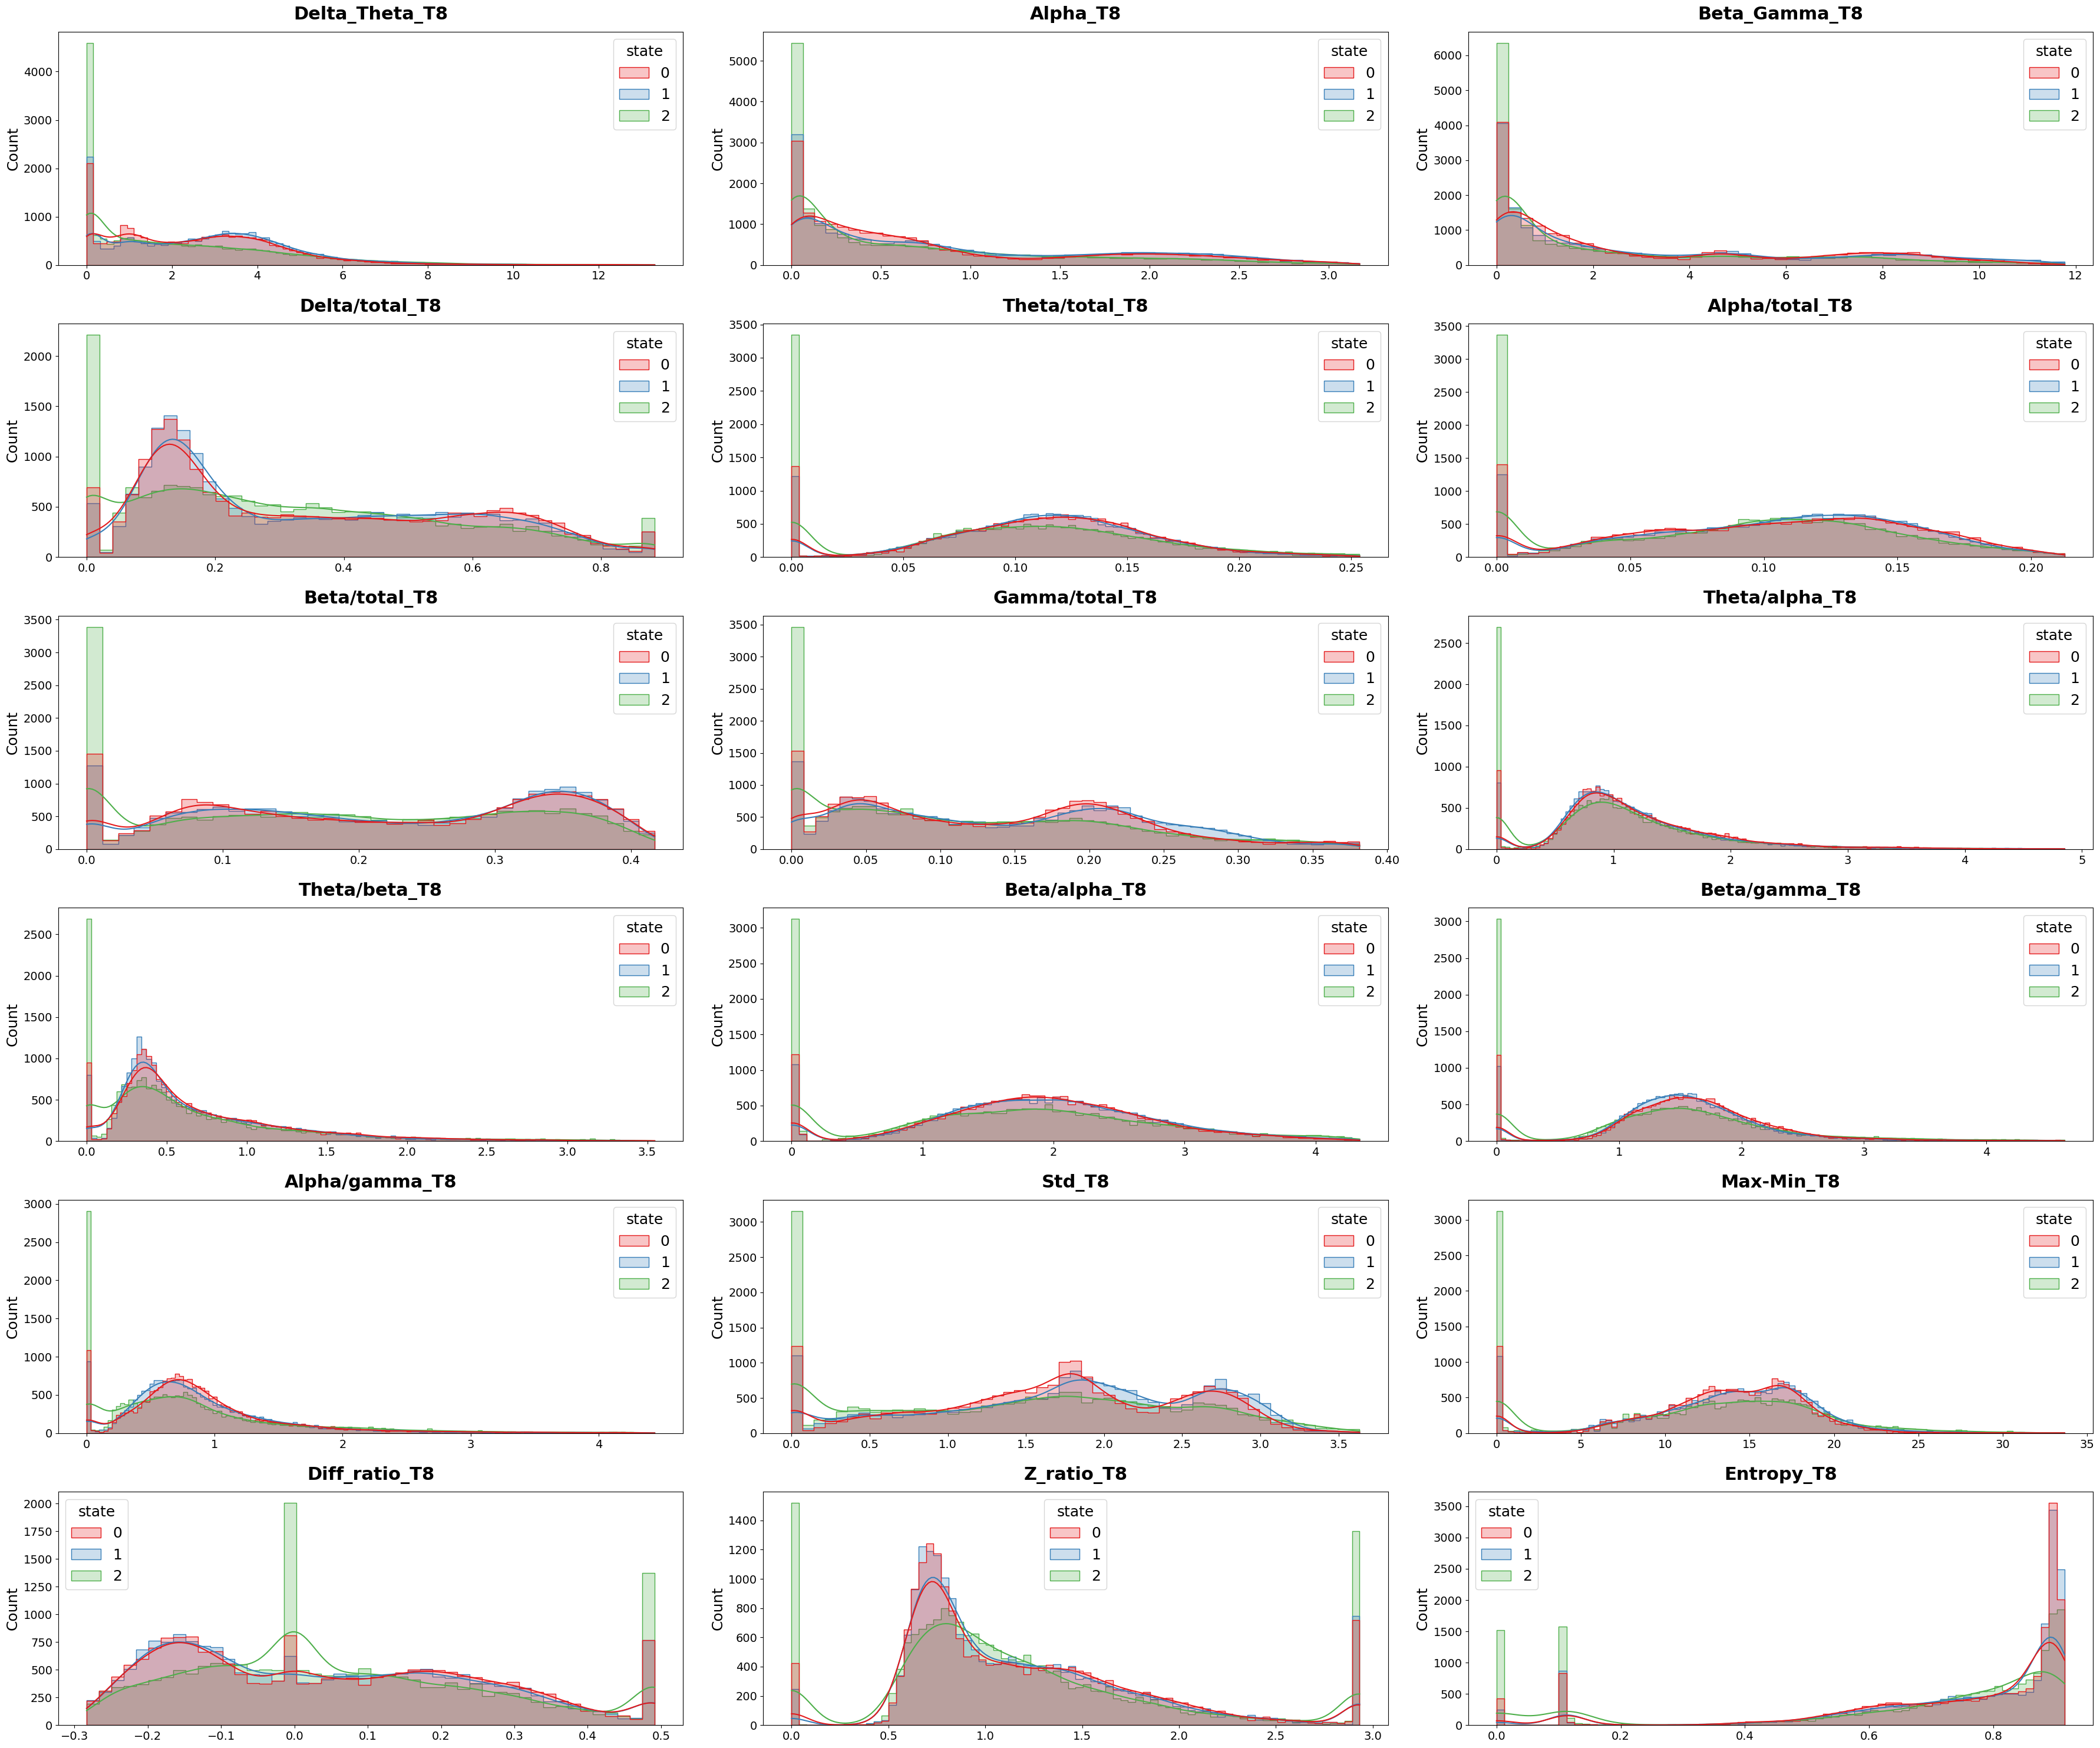

In [65]:
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator

def plot_feature_distributions(features_df, features_to_plot, replace, save=False):
    # --- Keep only first 1800 samples per filename ---
    features_df_reduce = (
        features_df.groupby(features_df.columns[0], group_keys=False)
        .head(60 * 30)
    )
    # features_df_reduce = features_df
    print(np.count_nonzero(features_df_reduce['state']==0))
    print(np.count_nonzero(features_df_reduce['state']==1))
    print(np.count_nonzero(features_df_reduce['state']==2))
    

    # Rename columns using mapping
    features_df_reduce = features_df_reduce.rename(columns=replace)
    features_to_plot = [replace[feature] for feature in features_to_plot]

    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(40, 30))

    for i, feature in enumerate(features_to_plot):
        ax = plt.subplot(6, len(features_to_plot) // 6, i + 1)

        # Remove outliers (1–99 percentile)
        lower, upper = np.percentile(features_df_reduce[feature], [2, 98])
        clean_data = features_df_reduce[
            (features_df_reduce[feature] >= lower) & (features_df_reduce[feature] <= upper)
        ]
        

        # Plot
        sns.histplot(
            data=clean_data,
            x=feature,
            hue='state',
            kde=True,
            element='step',
            palette='Set1',
            legend=True,
            # stat="density",        # ✅ normalize per class
            # common_norm=False,     # ✅ normalize independently
            ax=ax
        )

        ax.set_title(feature, fontsize=22, fontweight='bold', pad=15)
        ax.tick_params(axis='both', labelsize=14)
        ax.set_xlabel("")
        ax.set_ylabel("Count")
        
        # handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles, ['Relax', 'Break', 'Focus'], title='State', fontsize=14, title_fontsize=15)

    

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    if save:
        plt.savefig(f'feature_distributions_{Ch}.pdf', bbox_inches='tight', pad_inches=0.2)
    plt.show()
    
# keep_columns = [
#     'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2',
#     'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'state'
# ]
    
Ch = 'T8'
features_to_plot = [f"welch_{idx}_{Ch}" for idx in range(len(FEATURE_NAMES))]
replace = {features_to_plot[idx]: f"{feat}_{Ch}" for idx, feat in enumerate(FEATURE_NAMES)}
plot_feature_distributions(df_welch, features_to_plot, replace, save=True)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


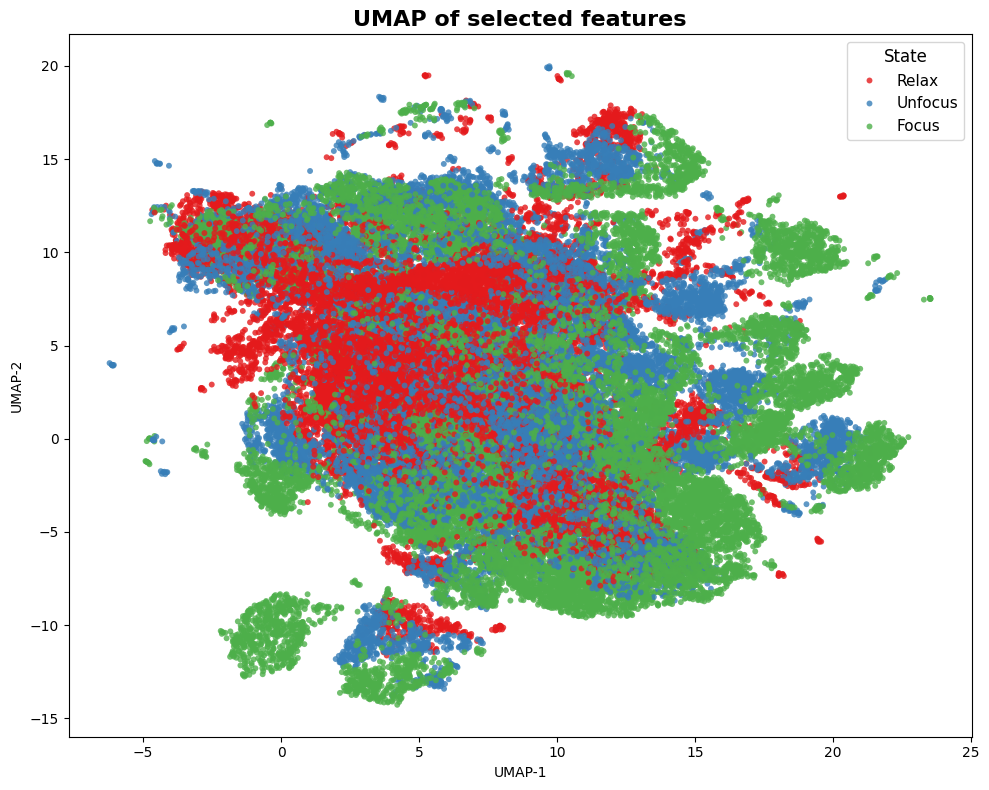

In [20]:
# If needed: pip install umap-learn
# %pip install umap-learn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap.umap_ as umap

def plot_umap(features_df, features_to_plot, title_suffix="", save=True,
              n_neighbors=25, min_dist=0.15, metric="cosine", use_pca=True, pca_n=50,
              state_map={0:'Focus', 1:'Unfocus', 2:'Relax'}):
    """
    Projects selected features to 2D with UMAP and scatters points colored by 'state'.
    - Keeps the first 60*30 rows per filename (like your histogram code).
    - Standardizes features before UMAP (and optional PCA->UMAP pipeline).
    """

    df = (features_df.groupby(features_df.columns[0], group_keys=False)
                    .head(60*30)).copy()


    X = df[features_to_plot]
    y = df['state']

    Xs = StandardScaler().fit_transform(X.values)

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42
    )

    y_named = y.map(state_map).fillna(y.astype(str))
    if use_pca:
        # Cap PCA dim to min(pca_n, n_features)
        pca_dim = min(pca_n, Xs.shape[1])
        Xp = PCA(n_components=pca_dim, random_state=42).fit_transform(Xs)
        emb = reducer.fit_transform(Xp)
    else:
        emb = reducer.fit_transform(Xs)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=emb[:, 0], y=emb[:, 1],
        hue=y_named, palette='Set1', s=18, alpha=0.8, linewidth=0
    )
    plt.title(f"UMAP of selected features {title_suffix}".strip(), fontsize=16, fontweight='bold')
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title='State', fontsize=11, title_fontsize=12, loc='best', frameon=True)
    plt.tight_layout()

    if save:
        outname = f"umap.pdf"
        plt.savefig(outname, bbox_inches='tight', pad_inches=0.2)

    plt.show()

features_to_plot = [f"welch_{idx}_{Ch}" for Ch in Plot_Channels for idx in range(len(FEATURE_NAMES))]

plot_umap(
    df_welch,
    features_to_plot=features_to_plot,
    title_suffix=f"",                # appears in title/filename
    save=True,                        # writes a PDF
    n_neighbors=25, min_dist=0.9,    # tweak for separation vs. compactness
    metric="cosine",                  # often good for spectral features
    use_pca=False, pca_n=50            # PCA->UMAP pipeline (more stable)
)    

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

best_fold = 9
best_model = None
best_means = None
best_stds = None
max_init_duration_sec = 300
'''
https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/discussion/145650
The first 7 experiments belong to Subject 1, the next 7 experiments belong to Subject 2, and go on. 
However, Subject 5 could not complete the last experiment. 
Therefore, there are 34 records in the dataset.
'''
df_welch = pd.read_csv("welch_data_8s_14c.csv")
save_dict = {key: [] for key in ["acc_train", "acc_test"]}

sesssion_ind = True
results = []
exclude_files = []
list_filenames = list(df_welch['filename'].unique())

features_idx = [f"welch_{idx}_{Ch}" for Ch in Plot_Channels for idx in range(len(FEATURE_NAMES))]

if sesssion_ind:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    list_filenames = list(df_welch['filename'].unique())

    for fold, (train_idx, test_idx) in enumerate(kf.split(list_filenames)):
        print(f"\n==== Fold {fold} ====")
        train_subjects = [list_filenames[i] for i in train_idx if list_filenames[i] not in exclude_files]
        test_subjects  = [list_filenames[i] for i in test_idx  if list_filenames[i] not in exclude_files]

        train_df = df_welch[df_welch['filename'].isin(train_subjects)]
        test_df  = df_welch[df_welch['filename'].isin(test_subjects)]

        X_train, y_train = create_features_without_initial(train_df, features_to_add= features_idx)
        X_test,  y_test  = create_features_without_initial(test_df, features_to_add = features_idx)
        
        
        counts = np.bincount(y_train)
        if (len(counts) > 2):
            print(f"N.o 0: {counts[0]}, N.o 1: {counts[1]}, N.o 2: {counts[2]}")
        else:
            print(f"N.o 0: {counts[0]}, N.o 1: {counts[1]}")


        assert set(np.unique(y_train)) == {0,1,2}, "Training data must include all classes."

        clf = xgb.XGBClassifier(
            n_estimators=25, max_depth=3, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            objective="multi:softprob",  # use softprob if you need probabilities
            num_class=3
        )


        # Initialize the SVM Classifier
        # clf = HistGradientBoostingClassifier(
        # max_iter=25,          # Number of boosting iterations (similar to n_estimators)
        # max_depth=3,          # Maximum depth of each tree
        # learning_rate=0.1,    # Learning rate (same as XGBoost)
        # random_state=42       # For reproducibility
        # )

        # clf = SVC(
        # kernel='rbf',         # Use the RBF kernel for non-linear classification
        # C=1,                # Regularization parameter (controls trade-off between margin and error)
        # gamma='scale',        # Kernel coefficient (default 'scale' works well)
        # random_state=42       # For reproducibility
        # )

        # clf = RandomForestClassifier(
        #     n_estimators=25,
        #     max_depth=3,
        #     max_samples=0.8,
        #     max_features=0.8,
        #     random_state=42
        # )

        # Fit the model
        clf.fit(X_train, y_train)

        if fold == best_fold:
            best_model = clf



        # y_pred_train = clf.predict(X_train)
        y_proba = clf.predict_proba(X_train)
        y_pred_train = np.argmax(y_proba, axis=1)
        accuracy_train = accuracy_score(y_train, y_pred_train)
        save_dict["acc_train"].append(accuracy_train)

        # y_pred_test = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        y_pred_test = np.argmax(y_proba, axis=1)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        save_dict["acc_test"].append(accuracy_test)

        print("*"*40)
        print(f"Fold {fold}: accuracy_train = {accuracy_train} --> accuracy_test = {accuracy_test}")
else:
    # Build the full pooled dataset once
    X, y = create_features_without_initial(df_welch, features_to_add= features_idx)
    # Ensure numpy arrays
    X = np.asarray(X)
    y = np.asarray(y)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"\n==== Fold {fold} ====")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        counts = np.bincount(y_train)
        if (len(counts) > 2):
            print(f"N.o 0: {counts[0]}, N.o 1: {counts[1]}, N.o 2: {counts[2]}")
        else:
            print(f"N.o 0: {counts[0]}, N.o 1: {counts[1]}")


        assert set(np.unique(y_train)) == {0,1,2}, "Training data must include all classes."

        clf = xgb.XGBClassifier(
            n_estimators=25, max_depth=3, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            objective="multi:softprob",  # use softprob if you need probabilities
            num_class=3
        )


        # Initialize the SVM Classifier
        # clf = HistGradientBoostingClassifier(
        # max_iter=25,          # Number of boosting iterations (similar to n_estimators)
        # max_depth=3,          # Maximum depth of each tree
        # learning_rate=0.1,    # Learning rate (same as XGBoost)
        # random_state=42       # For reproducibility
        # )

        # clf = SVC(
        # kernel='rbf',         # Use the RBF kernel for non-linear classification
        # C=1,                # Regularization parameter (controls trade-off between margin and error)
        # gamma='scale',        # Kernel coefficient (default 'scale' works well)
        # random_state=42       # For reproducibility
        # )

        # clf = RandomForestClassifier(
        #     n_estimators=25,
        #     max_depth=3,
        #     max_samples=0.8,
        #     max_features=0.8,
        #     random_state=42
        # )

        # Fit the model
        clf.fit(X_train, y_train)

        if fold == best_fold:
            best_model = clf



        # y_pred_train = clf.predict(X_train)
        y_proba = clf.predict_proba(X_train)
        y_pred_train = np.argmax(y_proba, axis=1)
        accuracy_train = accuracy_score(y_train, y_pred_train)
        save_dict["acc_train"].append(accuracy_train)

        # y_pred_test = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        y_pred_test = np.argmax(y_proba, axis=1)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        save_dict["acc_test"].append(accuracy_test)

        print("*"*40)
        print(f"Fold {fold}: accuracy_train = {accuracy_train} --> accuracy_test = {accuracy_test}")
  

results_df = pd.DataFrame(save_dict) # pd.DataFrame({'random_state': range(100), 'acc_train': accuracies_train, 'acc_test': accuracies_test})



==== Fold 0 ====
N.o 0: 16258, N.o 1: 16200, N.o 2: 14310
****************************************
Fold 0: accuracy_train = 0.7664428669175505 --> accuracy_test = 0.6553170490994326

==== Fold 1 ====
N.o 0: 16258, N.o 1: 16200, N.o 2: 14310
****************************************
Fold 1: accuracy_train = 0.7861358193636675 --> accuracy_test = 0.6575376264495435

==== Fold 2 ====
N.o 0: 16258, N.o 1: 16200, N.o 2: 14310


In [89]:
import joblib
import os

max_index = results_df["acc_test"].idxmax()
acc_test =  results_df["acc_test"][max_index]
acc_train = results_df["acc_train"][max_index]
print(f"Train accuracy {acc_train}, Maximum test accuracy: {acc_test}")
print("At state:", max_index)
model_dir = 'models_v01'
model_path = os.path.join(model_dir, f"xgb_model.pkl")

joblib.dump(best_model, model_path)


Train accuracy 0.7796282589028704, Maximum test accuracy: 0.7086774851812263
At state: 4


['models_v01/xgb_model.pkl']